In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import pandas as pd
import splat
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import numba
from tqdm import tqdm
import splat.empirical as spem
import wisps.simulations.effective_numbers as ef 
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
import matplotlib as mpl
import splat.empirical as spe

%matplotlib inline

In [2]:
pnts=wisps.OBSERVED_POINTINGS

In [3]:
def bin_by_spt_bin(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def iswithin_mag_limits(mags, pnt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k])
    return np.logical_or.reduce(flags)


In [4]:
sgrid=wispsim.SPGRID

In [5]:
cands=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [6]:
cands['spt']=cands.spectra.apply(lambda x: x.spectral_type)

In [7]:
pnt_names=[x.name for x in pnts]

In [8]:
pnt_names.index('par1')

149

In [9]:
pnts[0].survey

'hst3d'

In [10]:
def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]
    

def get_mags(row):
    return pd.Series(row.spectra.mags)

In [11]:
mags_df=cands.apply(get_mags, axis=1)
tab=wisps.Annotator.reformat_table(cands.join(mags_df))
tab['pnt']=tab['grism_id'].apply(get_pointing)

In [12]:
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')
flags=[iswithin_mag_limits(x, y) for x, y in zip(obsmgs, tab.pnt.values)]

cdf_to_use=tab[flags]
nobs=wisps.custom_histogram(cdf_to_use.spt.apply(wisps.make_spt_number), sgrid, 1)

In [13]:
spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
cnorm=Normalize(wispsim.HS[0], wispsim.HS[-1])

In [14]:
data=(ef.simulation_outputs()['baraffe2003'])[100]

In [15]:
data.keys()

dict_keys(['f110', 'f140', 'f160', 'd', 'r', 'z', 'appf140', 'appf110', 'appf160', 'snrj', 'sl', 'pnt', 'spts', 'teff'])

In [16]:
def compute_simulated_numbers(hidx, model='saumon2008', selection='prob'):
    #an index in accordance with the scale height
    
    data=(ef.simulation_outputs()[model])[hidx]

    simdf=pd.DataFrame()
    simdf['spt']=data['spts'].flatten()
    simdf['teff']=data['teff'].flatten()
    simdf['slprob']=data['sl']
    simdf['snr']=data['snrj']
    simdf['appF140']=data['appf140']
    simdf['appF110']=data['appf110']
    simdf['appF160']=data['appf160']
    simdf['pntname']=data['pnt']
    
    simdf['pnt']=simdf.pntname.apply(lambda x: np.array(pnts)[pnt_names.index(x)])
    
    simmgs=simdf[['appF140', 'appF110', 'appF160']].rename(columns={"appF110": "F110", 
                                                                    "appF140": "F140",
                                                                    "appF160": "F160"}).to_dict('records')
    flags=[iswithin_mag_limits(x, y) for x, y in zip(simmgs,  simdf.pnt.values)]
    
    
    cutdf=(simdf[flags]).reset_index(drop=True)
    NORM = 0.63*(10**-3)/ len(cutdf.teff[np.logical_and(cutdf.teff>=1650, cutdf.teff <=1800)])
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros(len(wispsim.SPGRID))))
    #rounded spectral type
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        NSIM[g[0]]=np.nansum((g[1]).slprob*NORM)
        
    return NSIM

In [17]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

In [18]:
VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [19]:
import seaborn as sns
#flatui =['#001f3f', '#0074D9', '#7FDBFF', '#39CCCC', '#3D9970', '#2ECC40', '#01FF70', '#FFDC00']
sns.set_palette(sns.color_palette("husl"))
#sns.set_palette(sns.color_palette(flatui, len(wispsim.HS)))

7it [1:29:43, 769.06s/it]


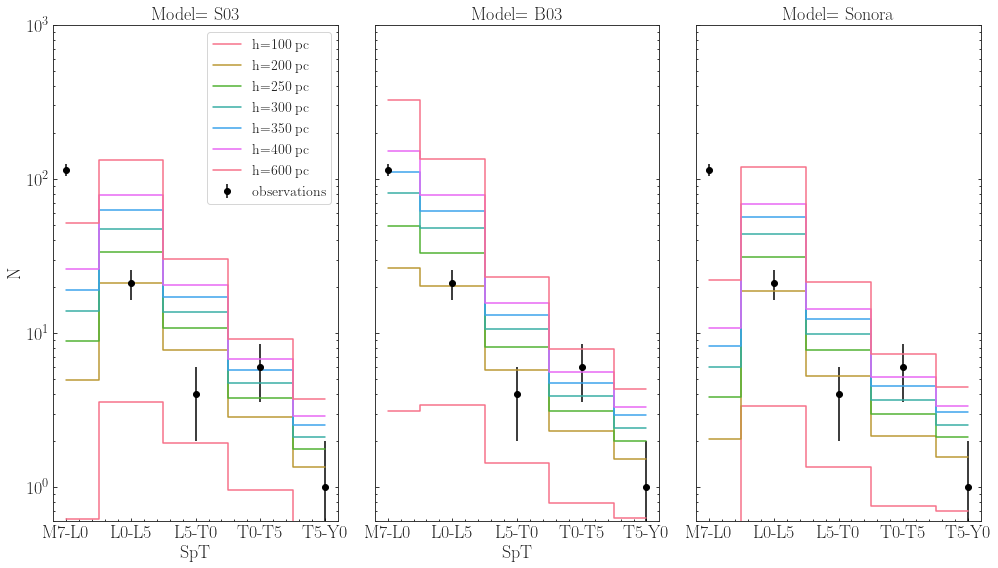

In [20]:
fig, (ax, ax1, ax2)=plt.subplots(figsize=(14, 8), ncols=3, sharey=True, sharex=True)


nexpct=[]
for idx, h in tqdm(enumerate(wispsim.HS)):
    
    nsimulated_saumon=compute_simulated_numbers(h, model='saumon2008')
    nsimulated_baraffe=compute_simulated_numbers(h, model='baraffe2003' )
    nsimulated_sonora=compute_simulated_numbers(h, model='marley2019' )
    
    ns_bar=[]
    ns_saumon=[]
    ns_sonora=[]
    for s in wispsim.SPGRID:
            ns_bar.append(nsimulated_baraffe[s])
            ns_saumon.append(nsimulated_saumon[s])
            ns_sonora.append(nsimulated_sonora[s])
    
        
    ns_bar=np.array(ns_bar)
    ns_saumon=np.array(ns_saumon)
    ns_sonora=np.array(ns_sonora)
    
    
    
    ax1.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns_bar*VOLUMES[idx]), 
                 where='mid', label='h={} pc'.format(wispsim.HS[idx]))
    
    ax.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns_saumon*VOLUMES[idx]),
            where='mid', label='h={} pc'.format(wispsim.HS[idx]))
    
    ax2.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns_sonora*VOLUMES[idx]),
            where='mid', label='h={} pc'.format(wispsim.HS[idx]))
    
    nexpct.append( bin_by_spt_bin(wispsim.SPGRID,ns_bar*VOLUMES[idx]))
    



ax.set_yscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax.set_ylim([0.6, 1000])
ax1.set_ylim([0.6, 1000])
ax2.set_ylim([0.6, 1000])

y2=bin_by_spt_bin(wispsim.SPGRID,nobs)
dy2=np.sqrt(y2)
ax1.errorbar(spgrid2,y2, yerr=dy2,
            label='observations',fmt='o', color='k')
ax.errorbar(spgrid2,y2, yerr=dy2,
            label='observations',fmt='o', color='k')
ax2.errorbar(spgrid2,y2, yerr=dy2,
            label='observations',fmt='o', color='k')




ax1.set_xlabel('SpT',fontsize=18)

ax.set_xlabel('SpT',fontsize=18)
ax.set_ylabel('N',fontsize=18)

ax.set_title('Model= S03', fontsize=18)
ax1.set_title('Model= B03', fontsize=18)
ax2.set_title('Model= Sonora', fontsize=18)
ax.legend(fontsize=14, loc='upper right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')


In [22]:
#visually inspect all templates you used for the classification
#how many things star_flag and sexctrator says are point-sources and vice-versa
#raise the binary fraction to 20%
#it's okay to scale in temperature 
#all spectral primary spectral types must less than secondary spectral types
#scale them by their absolute 
#use daniella's criteria to get rid of spcectral binaries and burgasser 2010 
#the binary composite spectral type
#(1) must have parallax
#(2) cross-match with daniella's table put an excel 
#(3) must scale them by flux
#(4) secondary must be less than primary in spt 
#(5) also color code them by delta spt (primary spt-secondary spt 
#use (best 2018) and peacaut 2019
#double check that m1> m2 for the mass ratios
#double mass ratio s